In [1]:
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import re
import ast
import string
import unidecode
from collections import defaultdict
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Embedding, concatenate, Input, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from nltk import word_tokenize
from nltk.corpus import stopwords

import NED_models

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
from sklearn import metrics

In [3]:
with open("../data/word2idx/word2idx.pkl", "rb") as f:
    #Map any unknown word to UNKNOWN, which has index 1
    word2idx = pickle.load(f)

In [4]:
len(word2idx)

445881

In [5]:
data = pd.read_csv('../data/sample_data_1percent.csv')

In [6]:
conditions = data.link_anchor.str.contains('#', na=False)
data = data[~conditions]
data = data.reset_index().drop('index', axis=1)

In [7]:
data.head()

,text,link_anchor,link_start,link_end,target_wikidata,tokenized_vector,candidates
0,the academy awards also officially and popular...,film industry,120,133,1415395,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[93196.0, 2973146.0, 2973208.0, 2973157.0, 328..."
1,the academy awards also officially and popular...,academy of motion picture arts and sciences,156,199,212329,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[212329.0, 212329.0]"
2,the academy awards also officially and popular...,art deco,551,559,173782,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[173782.0, 4824850.0, 4796770.0, 23307613.0, 2..."
3,the academy awards also officially and popular...,george stanley,603,617,5544783,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[3101928.0, 5539480.0, 5544780.0, 5544779.0, 5..."
4,the academy awards also officially and popular...,cedric gibbons,642,656,727904,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[727904.0, 5057103.0]"


In [8]:
data.shape

(2459381, 7)

In [7]:
with open('../data/knowledge_graph_data/id2text_entity.pickle', 'rb') as f:
    id2text = pickle.load(f)

In [8]:
with open('../data/name_to_wiki_id.pkl', 'rb') as f:
    name_to_wiki_id = pickle.load(f)

In [9]:
with open('../data/knowledge_graph_data/idx2id_entity.pickle', 'rb') as f:
    idx2id = pickle.load(f)

In [10]:
id2idx = {value: key for key, value in idx2id.items()}

In [11]:
graph_embedding = np.load('../data/knowledge_graph_data/wiki_DistMult_entity.npy') 

In [12]:
# replace words within paranthesis and remove non alphanumeric characters
# get_rid of `the` which can cause difference
pattern = re.compile(r'\([^)]*\)|[^a-zA-Z0-9 -]|\s|(^|[^a-zA-Z0-9])the[^a-zA-Z0-9]')
# unidecode to remove accents
normalize_text = lambda text: pattern.sub("", unidecode.unidecode(text).lower())


In [13]:
#window length actually 2 times this since from both sides
window_length = 10

In [16]:
#For each of the entities in each of the rows, make word2idx vector using context window and also get graph embedding.

#lstm_input = []
#graph_input = []
# doc_input = []
#response = []
#not_in_graph = []

lstm_input_list = []
# corresponds to each candidate
graph_input_list = []

for i, article in tqdm_notebook(data.iterrows(), total = len(data)):
    text = article['text']
#     doc_embedding = docs[i][0]
#     for entity, indices in article[1].items():
    name = article['link_anchor']
    entity_id = article['target_wikidata']
    #Don't include actual entity text for now in context window since doing fixed length? 
    indices = np.array([int(c) for c in list(article['tokenized_vector']) if c.isdigit()])
    entity_idx = np.where(indices == 1)[0]
    if len(entity_idx):
        split_text = text.split()
        context = split_text[max(0, entity_idx.min() - window_length) : entity_idx.min()] +\
                  split_text[entity_idx.max() + 1 : entity_idx.max() + window_length + 1] 
        #if word not in vocab, by default map to 1
        context_word2idx = [word2idx.get(word, 1) for word in context]
        
        #storing list of candidates in knowledge graph
        kge_candidates = []
        
        #get a candidate from candidate_dict to get a false, irrelevant entity for each entity
        if not pd.isnull(article['candidates']):
            candidates_list = ast.literal_eval(article['candidates'])[:10]
            #can't choose actual entity as false 
            if entity_id in candidates_list:
                candidates_list.remove(entity_id)
            if len(candidates_list) > 0:
                for false_entity_id in candidates_list:
                    if false_entity_id in id2idx:
                        false_graph_embed = graph_embedding[id2idx[false_entity_id]]
                        #lstm_input.append(context_word2idx)
                        #graph_input.append(false_graph_embed)
        #                 doc_input.append(doc_embedding)
                        #response.append(0)
                        kge_candidates.append(false_graph_embed)
                    else:
                        pass
                        #not_in_graph.append(false_entity_id)
        if entity_id in id2idx:
            true_graph_embed = graph_embedding[id2idx[entity_id]]
            #lstm_input.append(context_word2idx)
            #graph_input.append(true_graph_embed)
    #         doc_input.append(doc_embedding)
            #response.append(1)
            # this means that last index is always the true embedding
            kge_candidates.append(true_graph_embed)
            lstm_input_list.append(context_word2idx)
            graph_input_list.append(np.array(kge_candidates))
        
        else:
            pass
            #not_in_graph.append(entity_id)
            
#lstm_input = pad_sequences(lstm_input, maxlen = window_length * 2, padding = 'post')
# graph_input = np.array(graph_input)
# # doc_input = np.array(doc_input)
# response = np.array(response)

NameError: name 'lstm_input' is not defined

In [18]:
lstm_input_list = np.array(lstm_input_list)
graph_input_list = np.array(graph_input_list)

In [19]:
np.save("../data/model1/lstm_input_list.npy", lstm_input_list)
np.save("../data/model1/graph_input_list.npy", graph_input_list)

In [5]:
lstm_input_list = np.load("../data/model1/lstm_input_list.npy", allow_pickle = True)
graph_input_list = np.load("../data/model1/graph_input_list.npy", allow_pickle = True)

In [6]:
# lstm_input = np.load("../data/model1/lstm_input.pkl.npy")
# graph_input = np.load("../data/model1/graph_input.pkl.npy")
# response = np.load("../data/model1/response.pkl.npy")

In [7]:
# np.random.seed(1)

# train_ind, test_ind = train_test_split(np.arange(len(response)))
# lstm_train = lstm_input[train_ind]
# lstm_test = lstm_input[test_ind]
# graph_train = graph_input[train_ind]
# graph_test = graph_input[test_ind]
# # doc_train = doc_input[train_ind]
# # doc_test = doc_input[test_ind]
# y_train = response[train_ind]
# y_test = response[test_ind]

# len(y_train), len(y_test)

In [6]:
np.random.seed(1)

train_idx, test_idx = train_test_split(np.arange(len(lstm_input_list)), test_size=0.2)


In [7]:
len(train_idx)

1882452

In [8]:
len(test_idx)

470613

In [8]:
#indices = test_idx[:10]

In [9]:
def build_data(lstm_input_list, graph_input_list, indices):
    # construct lstm, graph set based on indices
    lstm_data = []
    graph_data = []
    response = []
    for ind in indices:
        lstm_inp = lstm_input_list[ind]
        graph_inp = graph_input_list[ind]
        for i, kge in enumerate(graph_inp):
            lstm_data.append(lstm_inp)
            graph_data.append(kge)
            if i == len(graph_inp)-1:
                response.append(1)
            else:
                response.append(0)
    lstm_data = np.array(lstm_data)
    lstm_data = pad_sequences(lstm_data, maxlen = window_length * 2, padding = 'post')
    graph_data = np.array(graph_data)
    response = np.array(response)

    return lstm_data, graph_data, response

In [10]:
window_length = 10
lstm_train, graph_train, y_train = build_data(lstm_input_list, graph_input_list, train_idx)
lstm_test, graph_test, y_test = build_data(lstm_input_list, graph_input_list, test_idx)

In [11]:
y_train.shape

(9363481,)

In [12]:
y_train.mean()

0.2010418988408264

In [13]:
y_test.shape

(2337813,)

In [14]:
y_test.mean()

0.20130480923837793

In [15]:
np.concatenate([y_train, y_test]).mean()

0.20109442596690588

In [16]:
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(y_train),
                                            y_train)

In [17]:
lstm_train.shape

(9363481, 20)

In [18]:
graph_train.shape

(9363481, 250)

In [17]:
# model -> classification at different abstaining conditions -> do not classify if abstaining rate is high
# vs recall
# evaluate on all vs only false

In [ ]:
# def biLSTM_KGE_context_model(lstm_input_shape, graph_input_shape, dict_size):
#     inp1 = Input(shape = (lstm_input_shape[1], ))
#     inp2 = Input(shape = (graph_input_shape[1], ))
#     embed = Embedding(output_dim=100, input_dim=dict_size, input_length=lstm_input_shape[1])(inp1)
#     out1 = Bidirectional(LSTM(128))(embed)
#     w = concatenate([out1, inp2])
#     w = Dense(256, activation = 'relu')(w)
#     w = Dropout(0.2)(w)
#     out = Dense(1, activation = 'sigmoid')(w)
#     model = Model(inputs=[inp1, inp2], outputs=out)
#     return model

In [30]:
# inp1 = Input(shape = (lstm_train.shape[1], ))
# inp2 = Input(shape = (graph_train.shape[1], ))
# # inp3 = Input(shape = (doc_input.shape[1], ))
# embed = Embedding(output_dim=100, input_dim=len(word2idx), input_length=lstm_train.shape[1])(inp1)
# out1 = Bidirectional(LSTM(128))(embed)
# # out1 = LSTM(128)(embed)
# w = concatenate([out1, inp2])
# w = Dense(256, activation = 'relu')(w)
# w = Dropout(0.2)(w)
# out = Dense(1, activation = 'sigmoid')(w)
# model = Model(inputs=[inp1, inp2], outputs=out)
model = NED_models.biLSTM_KGE_context_model(lstm_train.shape, graph_train.shape, len(word2idx))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 20, 100)      44588100    input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 256)          234496      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 250)          0                                            
__________________________________________________________________________________________________
concatenat

In [31]:
# model.fit([lstm_train, graph_train, doc_train], y_train, batch_size = 256, epochs = 3, validation_split = 0.2)
model.fit([lstm_train, graph_train], y_train, batch_size = 8192, epochs = 5, validation_split = 0.2, class_weight = weights)

Train on 7490784 samples, validate on 1872697 samples
Epoch 1/5
7490784/7490784 [==============================] - 217s 29us/step - loss: 0.3911 - acc: 0.8287 - val_loss: 0.3421 - val_acc: 0.8482
Epoch 2/5
7490784/7490784 [==============================] - 203s 27us/step - loss: 0.3241 - acc: 0.8544 - val_loss: 0.3120 - val_acc: 0.8611
Epoch 3/5
7490784/7490784 [==============================] - 203s 27us/step - loss: 0.2881 - acc: 0.8696 - val_loss: 0.3025 - val_acc: 0.8656
Epoch 4/5
7490784/7490784 [==============================] - 203s 27us/step - loss: 0.2604 - acc: 0.8821 - val_loss: 0.3013 - val_acc: 0.8673
Epoch 5/5
7490784/7490784 [==============================] - 203s 27us/step - loss: 0.2374 - acc: 0.8929 - val_loss: 0.3069 - val_acc: 0.8669


In [32]:
model.save('final_NED_model.h5')

In [33]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])
y_test_pred_prob = model.predict([lstm_test, graph_test])

y_test_pred = np.where(y_test_pred_prob > 0.5, 1, 0)
accuracy_score(y_test, y_test_pred)

0.8672336067940422

In [34]:
cm = confusion_matrix(y_test, y_test_pred)

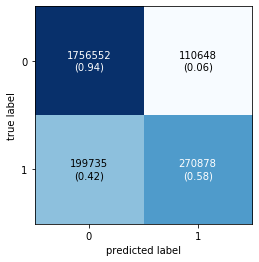

In [35]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(cm, show_normed = True);

In [36]:
metrics.roc_auc_score(y_test, y_test_pred_prob)

0.8999217625692385

In [37]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_test_pred_prob)

Text(0.5, 1.0, 'ROC curve')

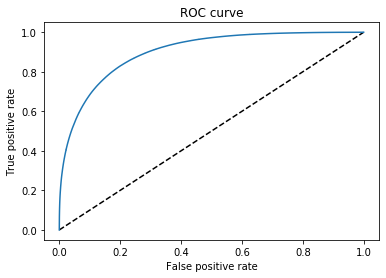

In [38]:
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [39]:
# see prediction score on candidate list

# find cutoff
# offset of where the true index is
cutoffs = [0]
for ind in test_idx:
    graph_inp = graph_input_list[ind]
    cutoffs.append(cutoffs[-1] + len(graph_inp))

In [40]:
candidate_test_acc = .0
count = len(cutoffs) - 1
print_count = 100
for start_idx, end_idx in zip(cutoffs, cutoffs[1:]):
    probs = y_test_pred_prob[start_idx:end_idx]
    #if np.argmax(probs) == len(probs) - 1:
    if max(probs) == probs[-1]:
        if np.random.randint(sum(probs == probs[-1])) == 0:
            candidate_test_acc += 1
    else:
        if print_count:
            print(probs[-1], max(probs))
            print_count -= 1
candidate_test_acc /= count

[0.02535573] [0.03843069]
[0.04891789] [0.06184092]
[0.38317108] [0.6380092]
[0.19910836] [0.27743357]
[0.43856007] [0.51543844]
[0.01073903] [0.01580426]
[0.07918218] [0.20278618]
[0.2972404] [0.645008]
[0.5406719] [0.55159163]
[0.3059118] [0.5111166]
[0.11643821] [0.43925825]
[0.37994787] [0.81701]
[0.0225499] [0.9024589]
[0.31105423] [0.48204577]
[0.01324478] [0.03938416]
[0.24200988] [0.74265015]
[0.14997527] [0.41232342]
[0.13210854] [0.39240828]
[0.536913] [0.60214484]
[0.01168835] [0.02487546]
[0.53221166] [0.56887186]
[0.29074273] [0.84012204]
[0.04859689] [0.21178856]
[0.32288003] [0.3766907]
[0.0650402] [0.31802377]
[0.30267942] [0.707274]
[0.3928599] [0.4062578]
[0.11879975] [0.7094199]
[0.25333267] [0.3848415]
[0.49757978] [0.7075999]
[0.39237273] [0.55555284]
[0.388435] [0.45035046]
[0.42331448] [0.66753644]
[0.5963926] [0.7963102]
[0.46473426] [0.56557417]
[0.04805946] [0.20749822]
[0.43467587] [0.5562523]
[0.09366417] [0.6464339]
[0.47154936] [0.6525525]
[0.29346022] [0.

In [41]:
candidate_test_acc

0.7577266246363785

In [42]:
half_size = round(len(test_idx)/2)
abst_val_idx, abst_test_idx = test_idx[:half_size], test_idx[half_size:]
abst_val_cutoffs, abst_test_cutoffs = cutoffs[:half_size+1], cutoffs[half_size:]

In [43]:
num_tr = 20
thresholds = 1./num_tr * np.arange(num_tr)

In [44]:
recall_with_abstain = []
acc_after_abstain = []
abstain_rate = []
abst_val_count = len(abst_val_cutoffs) - 1
# abstain below the threshold
for tr in thresholds:
    recall = .0
    acc = .0
    abst = .0
    for start_idx, end_idx in zip(abst_val_cutoffs, abst_val_cutoffs[1:]):
        probs = y_test_pred_prob[start_idx:end_idx]
        max_prob = max(probs)
        if max_prob <= tr:
            abst += 1
        else:
            if max_prob == probs[-1]:
                if np.random.randint(sum(probs == probs[-1])) == 0:
                    acc += 1
    
    # only count non abst cases
    recall = acc / abst_val_count
    acc /= (abst_val_count - abst)
    
    recall_with_abstain.append(recall)
    acc_after_abstain.append(acc)
    abstain_rate.append(abst/abst_val_count)

Text(0, 0.5, 'Recall')

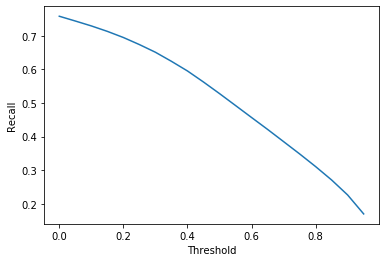

In [45]:
plt.plot(thresholds, recall_with_abstain)
plt.xlabel("Threshold")
plt.ylabel("Recall")

Text(0, 0.5, 'Precision (excluding abstained)')

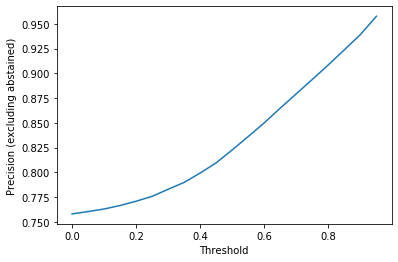

In [46]:
plt.plot(thresholds, acc_after_abstain)
plt.xlabel("Threshold")
plt.ylabel("Precision (excluding abstained)")

Text(0, 0.5, 'Precision (excluding abstained)')

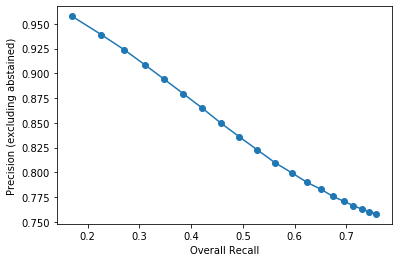

In [47]:
plt.plot(recall_with_abstain, acc_after_abstain, 'o-')
plt.xlabel("Overall Recall")
plt.ylabel("Precision (excluding abstained)")

In [48]:
# without the true
false_positive_rate = []
false_abstain_rate = []
abst_val_count = len(abst_val_cutoffs) - 1
# abstain below the threshold
for tr in thresholds:
    fpr = .0
    abst = .0
    for start_idx, end_idx in zip(abst_val_cutoffs, abst_val_cutoffs[1:]):
        probs = y_test_pred_prob[start_idx:end_idx-1]
        if len(probs) == 0:
            continue
        max_prob = max(probs)
        if max_prob <= tr:
            abst += 1
        else:
            fpr += 1
    
    # only count non abst cases
    fpr /= abst_val_count
    abst /= abst_val_count
    
    false_positive_rate.append(fpr)
    false_abstain_rate.append(abst)

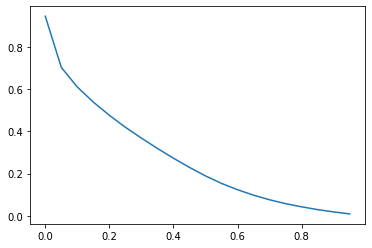

In [49]:
plt.plot(thresholds, false_positive_rate)

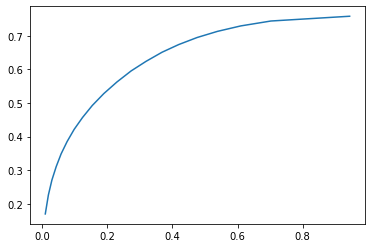

In [50]:
plt.plot(false_positive_rate, recall_with_abstain)

In [70]:
for th, rec, acc in zip(thresholds, recall_with_abstain, acc_after_abstain):
    print("Threshold: {}\nRecall: {:.3f}, Acc: {:.3f}".format(th,rec,acc))

Threshold: 0.0
Recall: 0.758, Acc: 0.758
Threshold: 0.05
Recall: 0.744, Acc: 0.760
Threshold: 0.1
Recall: 0.729, Acc: 0.763
Threshold: 0.15000000000000002
Recall: 0.713, Acc: 0.766
Threshold: 0.2
Recall: 0.695, Acc: 0.771
Threshold: 0.25
Recall: 0.674, Acc: 0.776
Threshold: 0.30000000000000004
Recall: 0.651, Acc: 0.783
Threshold: 0.35000000000000003
Recall: 0.624, Acc: 0.790
Threshold: 0.4
Recall: 0.595, Acc: 0.799
Threshold: 0.45
Recall: 0.562, Acc: 0.810
Threshold: 0.5
Recall: 0.528, Acc: 0.823
Threshold: 0.55
Recall: 0.492, Acc: 0.836
Threshold: 0.6000000000000001
Recall: 0.457, Acc: 0.850
Threshold: 0.65
Recall: 0.421, Acc: 0.865
Threshold: 0.7000000000000001
Recall: 0.385, Acc: 0.879
Threshold: 0.75
Recall: 0.348, Acc: 0.894
Threshold: 0.8
Recall: 0.311, Acc: 0.909
Threshold: 0.8500000000000001
Recall: 0.271, Acc: 0.924
Threshold: 0.9
Recall: 0.226, Acc: 0.939
Threshold: 0.9500000000000001
Recall: 0.170, Acc: 0.958


In [64]:
thresholds[0]

0.0

In [65]:
recall_with_abstain[0]

0.7579449737788242

In [66]:
acc_after_abstain[0]

0.7579449737788242

In [61]:
thresholds[1]

0.05

In [62]:
recall_with_abstain[0]

0.7579449737788242

In [63]:
acc_after_abstain[0]

0.7579449737788242

In [67]:
thresholds[2]

0.1

In [68]:
recall_with_abstain[0]

0.7579449737788242

In [69]:
acc_after_abstain[0]

0.7579449737788242

In [51]:
thresholds[3]

0.15000000000000002

In [52]:
recall_with_abstain[0]

0.7579449737788242

In [53]:
acc_after_abstain[0]

0.7579449737788242

In [54]:
recall_with_abstain[1]

0.7437464408047394

In [55]:
acc_after_abstain[1]

0.7603192325905717

In [56]:
abstain_rate[3]

0.06978997560623189

In [57]:
chosen_tr = thresholds[6]
abst_test_count = len(abst_test_cutoffs) - 1
# abstain below the threshold

recall = .0
acc = .0
abst = .0
for start_idx, end_idx in zip(abst_test_cutoffs, abst_test_cutoffs[1:]):
    probs = y_test_pred_prob[start_idx:end_idx]
    max_prob = max(probs)
    if max_prob <= chosen_tr:
        abst += 1
    else:
        if max_prob == probs[-1]:
            if np.random.randint(sum(probs == probs[-1])) == 0:
                acc += 1

# only count non abst cases
recall = acc / abst_test_count
acc /= (abst_test_count - abst)
abst /= abst_test_count

In [58]:
recall

0.6498064230983354

In [59]:
acc

0.7812744301546668

In [60]:
abst

0.16827378701016119